   #                                           Uber Fare Prediction

In [1]:
pip install geopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [56]:
import pandas as pd

#read the csv file
df = pd.read_csv("C:/Users/aksha/Downloads/uber.csv/uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Data Cleaning

In [57]:
# Data Exploration
print("\nData Summary:\n", df.describe())
print("\nData Info:\n", df.info())
print("\nMissing Values:\n", df.isnull().sum())


Data Summary:
          Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+05  200000.000000     200000.000000    200000.000000   
mean   2.771250e+07      11.359955        -72.527638        39.935885   
std    1.601382e+07       9.901776         11.437787         7.720539   
min    1.000000e+00     -52.000000      -1340.648410       -74.015515   
25%    1.382535e+07       6.000000        -73.992065        40.734796   
50%    2.774550e+07       8.500000        -73.981823        40.752592   
75%    4.155530e+07      12.500000        -73.967154        40.767158   
max    5.542357e+07     499.000000         57.418457      1644.421482   

       dropoff_longitude  dropoff_latitude  passenger_count  
count      199999.000000     199999.000000    200000.000000  
mean          -72.525292         39.923890         1.684535  
std            13.117408          6.794829         1.385997  
min         -3356.666300       -881.985513         0.000000  
25%           -7

In [58]:
# Drop any unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'key'])
# Drop rows with missing values
df = df.dropna()

In [71]:
# Convert 'pickup_datetime' to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract day, month, year, hour from 'pickup_datetime'
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour

In [60]:
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

Ensuring that pickup and dropoff coordinates are within valid geographic ranges i.e.,

Latitude must be between -90 and 90 ;
Longitude must be between -180 and 180

In [61]:
# Calculate the distance between pick-up and drop-off locations in km
df['distance_km'] = df.apply(lambda row: geopy.distance.distance(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).km, axis=1)

df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance_km
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,1.681111
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,2.454363
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,5.039603
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,1.661442
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,4.483730


In [62]:
df = df[df['distance_km'] > 0.1]   # Drop rows with zero or extremely low distance values

In [63]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance_km
count,193181.000000,193181.000000,193181.000000,193181.000000,193181.000000,193181.000000,193181.000000,193181.000000,193181.000000,193181.000000,193181.000000
mean,11.325360,-73.826438,40.646946,-73.836606,40.651185,1.684834,2011.749038,6.279857,15.700944,13.493853,21.287764
std,9.533968,3.661584,2.928109,3.544671,2.899322,1.307871,1.859536,3.440310,8.687465,6.513549,386.273949
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,1.000000,1.000000,0.000000,0.100198
25%,6.000000,-73.992267,40.736397,-73.991584,40.735260,1.000000,2010.000000,3.000000,8.000000,9.000000,1.296502
50%,8.500000,-73.982123,40.753267,-73.980545,40.753720,1.000000,2012.000000,6.000000,16.000000,14.000000,2.197413
75%,12.500000,-73.968446,40.767532,-73.965481,40.768330,2.000000,2013.000000,9.000000,23.000000,19.000000,3.977790
max,230.000000,40.808425,48.018760,40.831932,42.464187,6.000000,2015.000000,12.000000,31.000000,23.000000,8783.593498


### Exploratory Data Analysis (EDA)

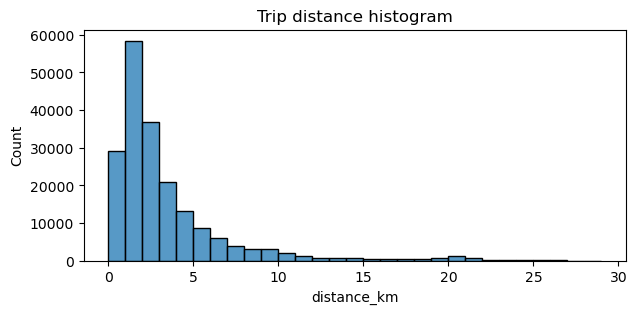

In [64]:
# Creating histogram of trip_distance
plt.figure(figsize=(7,3))
sns.histplot(df['distance_km'], bins=range(0,30,1))
plt.title('Trip distance histogram');

This visualization shows that majority of the trips distance were less than 5km

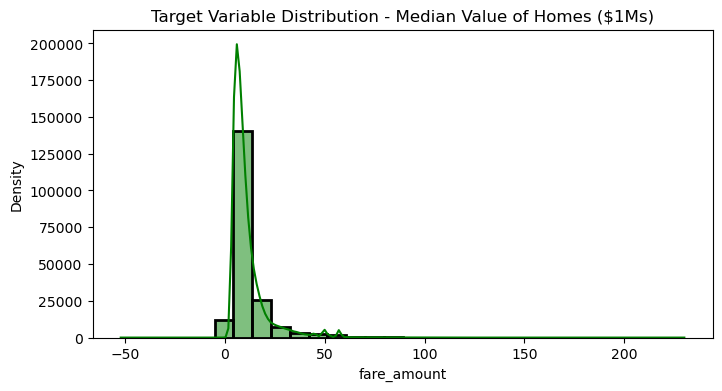

In [65]:
#Defining the target variable 
target = 'fare_amount'

#Distribution of fare_amount
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[8, 4])
sns.histplot(df[target], color='g', edgecolor="black", linewidth=2, bins=30, kde=True)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.xlabel('fare_amount') 
plt.ylabel('Density')
plt.show()

###### Rides per Day

In [66]:
df['day'] = pd.to_datetime(df['pickup_datetime']).dt.day_name()

# Group by 'day' and count occurrences
daily_rides = df.groupby('day').size()

# Reindex to ensure the days are in the correct order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_rides = daily_rides.reindex(day_order)
daily_rides

day
Monday       24355
Tuesday      27192
Wednesday    28048
Thursday     28994
Friday       29823
Saturday     29261
Sunday       25508
dtype: int64

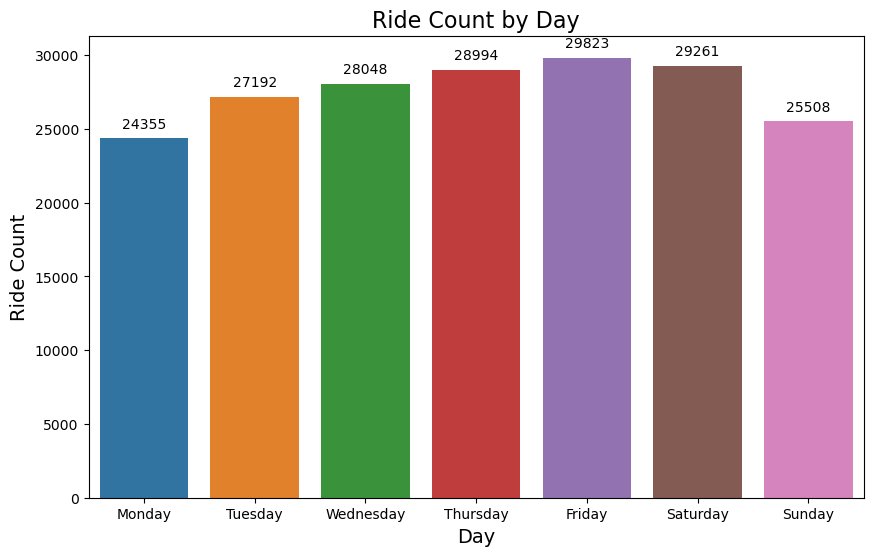

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting rides per day
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=daily_rides.index, y=daily_rides.values, order=day_order)

# Add counts on top of each bar
for i, count in enumerate(daily_rides.values):
    ax.text(i, count + 500, f'{count}', ha='center', va='bottom', fontsize=10)

    plt.title('Ride Count by Day', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Ride Count', fontsize=14)
plt.show()

This pattern suggests that the end of the workweek and weekend activities are the main reasons why ride requests are most common during these days. The fact that fares tend to rise during the week and peak on Friday may indicate that demand causes rides to be longer or more costly on these days.

Demand is highest on Thursdays and Fridays when people commute or socialize, while Saturdays are when most people spend their time relaxing.

###### Revenue Per Day

In [68]:
df_without_date = df.drop(columns=['pickup_datetime'])
total_amount_per_day = df_without_date.groupby(by='day').sum()[['fare_amount']]
total_amount_per_day = total_amount_per_day.reindex(index=day_order)
total_amount_per_day

,fare_amount
day,
Monday,277136.06
Tuesday,301201.12
Wednesday,317481.91
Thursday,332490.54
Friday,340036.55
Saturday,321459.41
Sunday,298038.76


Text(0.5, 1.0, 'Revenue by day')

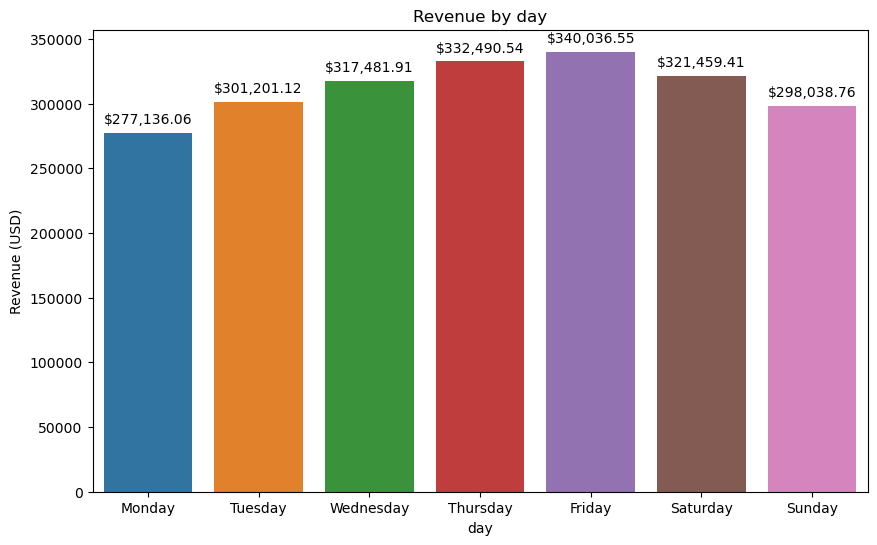

In [69]:
#Plotting revenue per day
plt.figure(figsize=(10,6))
ax = sns.barplot(x=total_amount_per_day.index, y=total_amount_per_day['fare_amount'])

# Add revenue values on top of each bar
for i, revenue in enumerate(total_amount_per_day['fare_amount']):
    ax.text(i, revenue + 5000, f'${revenue:,.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xticklabels(day_order)
ax.set_ylabel("Revenue (USD)")
plt.title("Revenue by day")

This indicates that Fridays have the highest fare amount ($340,036.55) in addition to the greatest ride count (29,823). This indicates a potential correlation where higher ride counts lead to increased fare amounts

###### Rides per month

In [70]:
# Convert month number to month name
df['month_name'] = df['pickup_datetime'].dt.month_name()

# Group by 'month_name' and count occurrences
monthly_rides = df.groupby('month_name').size()
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
monthly_rides = monthly_rides.reindex(month_order)
monthly_rides

month_name
January      17097
February     16133
March        18152
April        17981
May          18229
June         17186
July         14554
August       13646
September    14740
October      15652
November     14813
December     14998
dtype: int64

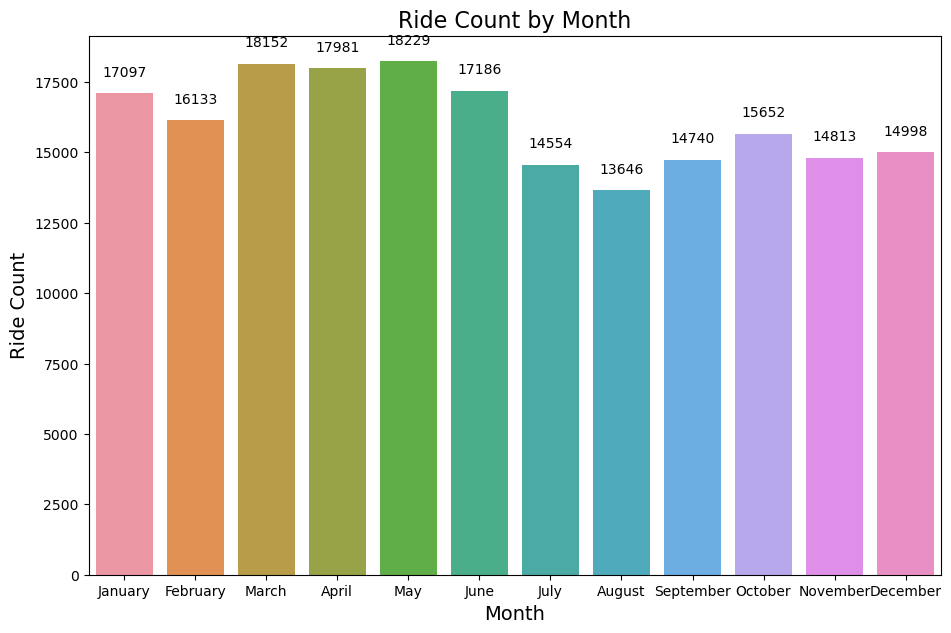

In [72]:
# Plotting rides per month
plt.figure(figsize=(11, 7))
ax = sns.barplot(x=monthly_rides.index, y=monthly_rides.values, order=month_order)

# Add counts on top of each bar
for i, count in enumerate(monthly_rides.values):
    ax.text(i, count + 500, f'{count}', ha='center', va='bottom', fontsize=10)

plt.title('Ride Count by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Ride Count', fontsize=14)
plt.show()

This visualisation shows that the ride counts tend to be higher in the spring and early summer months (i.e., March-May).

###### Fare amount vs passenger count

In [73]:
from scipy import stats

In [74]:
df.describe()[['fare_amount','passenger_count']]

,fare_amount,passenger_count
count,193181.000000,193181.000000
mean,11.325360,1.684834
std,9.533968,1.307871
min,-52.000000,0.000000
25%,6.000000,1.000000
50%,8.500000,1.000000
75%,12.500000,2.000000
max,230.000000,6.000000


In [75]:
df.groupby('passenger_count')[['fare_amount']].mean()

,fare_amount
passenger_count,
0,9.323280
1,11.206744
2,11.761229
3,11.462200
4,11.640264
5,11.225773
6,12.203810


As we can see the values of passenger count and fare amount are consistent and we don't see any relationship, but it can be because of random sampling. To find wether these values are statistically significant, let's do some hypothesis testing using ANOVA test.

###### Hypothesis

Null Hypothesis: There is no difference between average fare amount based on the no of passenger. 

Alternative Hypothesis: There is difference between average fare amount based on the no of passenger.

In [76]:
# Collect fare amounts for each passenger count in a list
fare_amounts = [df[df['passenger_count'] == i]['fare_amount'] for i in range(1, 7)]

# ANOVA test
result = stats.f_oneway(*fare_amounts)  # Unpacking the list for the test

# Print the results
print("F-statistic:", result.statistic)
print("p-value:", result.pvalue)

F-statistic: 24.615108554370245
p-value: 7.13241308967599e-25


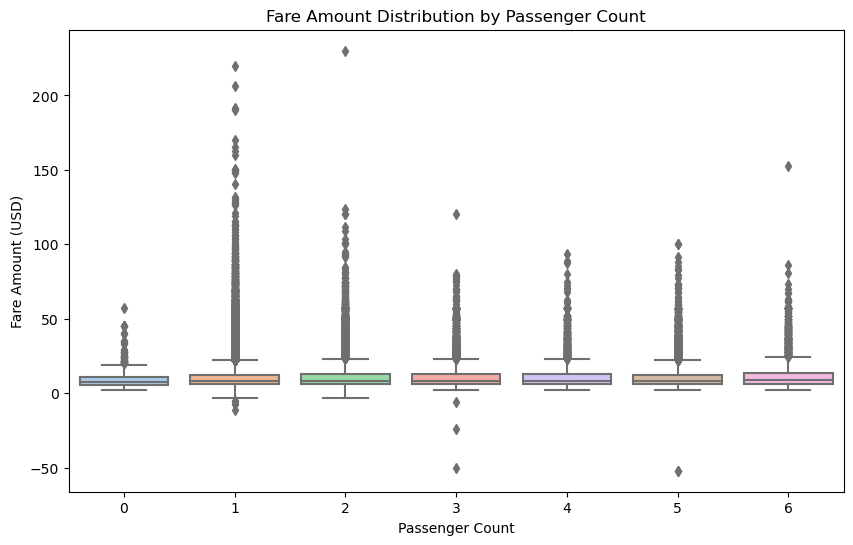

In [77]:
# Plotting the fare amount distribution by passenger count using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='fare_amount', data=df, palette='pastel')

# Adding titles and labels
plt.title('Fare Amount Distribution by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount (USD)')

plt.show()

Since the p-value is less than 0.05, the null hypothesis is rejected. This suggests that there is a statistically significant variance in average fare amounts depending on the number of passengers, which supports the alternative hypothesis, it means that the fare amount varies with the number of passengers.

###### Outlier detection using box plots:

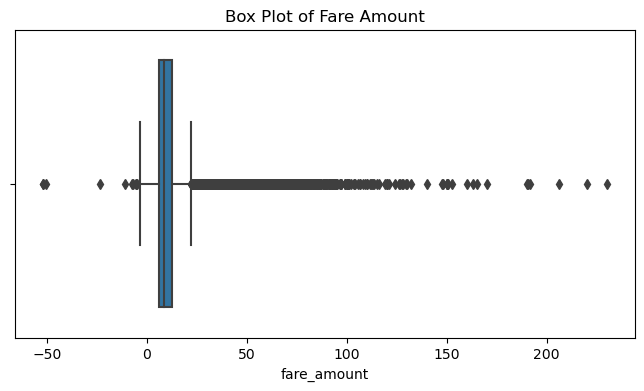

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot for 'fare_amount'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['fare_amount'])
plt.title('Box Plot of Fare Amount')
plt.show()

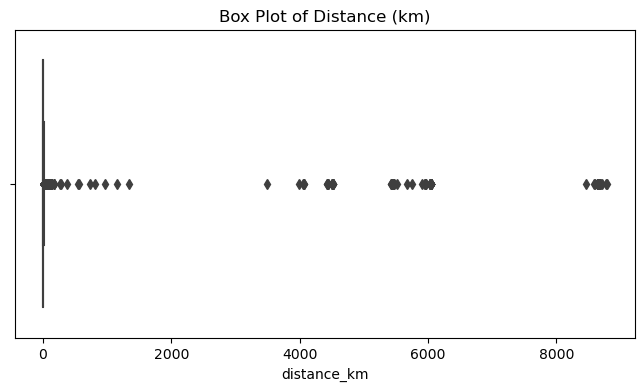

In [79]:
# Box plot for 'distance_km'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['distance_km'])
plt.title('Box Plot of Distance (km)')
plt.show()

In [80]:
# Outlier Handling
# Remove outliers in 'fare_amount' and 'distance_km' (i.e., unrealistic data)
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
df = df[df['distance_km'] < 100]

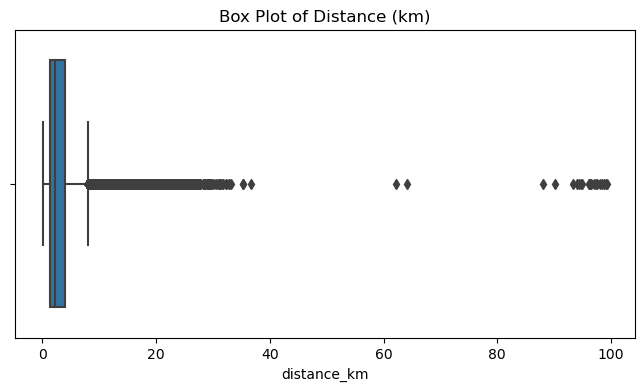

In [81]:
# Box plot for 'distance_km'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['distance_km'])
plt.title('Box Plot of Distance (km)')
plt.show()

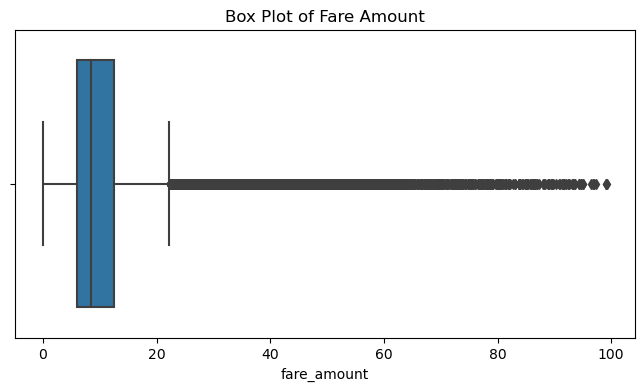

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot for 'fare_amount'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['fare_amount'])
plt.title('Box Plot of Fare Amount')
plt.show()

In [83]:
df.shape

(192649, 13)

In [85]:
df.columns
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance_km,month_name
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,1.681111,May
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,2.454363,July
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,5.039603,August
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,1.661442,June
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,4.483730,August


In [86]:
# Drop any unnecessary columns
df = df.drop(columns=['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','month_name'])
df.head()

,fare_amount,pickup_datetime,passenger_count,year,month,day,hour,distance_km
0,7.5,2015-05-07 19:52:06+00:00,1,2015,5,7,19,1.681111
1,7.7,2009-07-17 20:04:56+00:00,1,2009,7,17,20,2.454363
2,12.9,2009-08-24 21:45:00+00:00,1,2009,8,24,21,5.039603
3,5.3,2009-06-26 08:22:21+00:00,3,2009,6,26,8,1.661442
4,16.0,2014-08-28 17:47:00+00:00,5,2014,8,28,17,4.483730


### Performing ML models

In [88]:
df = df.drop(columns=['pickup_datetime'])

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192649 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      192649 non-null  float64
 1   passenger_count  192649 non-null  int64  
 2   year             192649 non-null  int64  
 3   month            192649 non-null  int64  
 4   day              192649 non-null  int64  
 5   hour             192649 non-null  int64  
 6   distance_km      192649 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 11.8 MB


In [90]:
# Define features and target variable
X = df[['passenger_count', 'year', 'month', 'day','hour', 'distance_km']]
y = df['fare_amount']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

###### 1. Linear Regression

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train and evaluate Linear Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression RMSE: 4.675024627438056
Linear Regression R2 Score: 0.7456842623319944


###### 2. Random Forest Regressor

In [93]:
from sklearn.ensemble import RandomForestRegressor

# Train and evaluate Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 3.8044073223716017
Random Forest R2 Score: 0.8315855125396892


###### 3. Gradient Boost Model

In [99]:
from sklearn.ensemble import GradientBoostingRegressor

# Train and evaluate Gradient Boosting
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("Gradient Boosting R2 Score:", r2_score(y_test, y_pred_gb))

Gradient Boosting RMSE: 3.6914536653745307
Gradient Boosting R2 Score: 0.8414375771264021


In [100]:
# Compare model performances
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
rmse = [np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_gb))]
r2 = [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_gb)]

performance_df = pd.DataFrame({'Model': models, 'RMSE': rmse, 'R2 Score': r2})
print("\nModel Performance Comparison:\n", performance_df)


Model Performance Comparison:
                Model      RMSE  R2 Score
0  Linear Regression  4.675025  0.745684
1      Random Forest  3.804407  0.831586
2  Gradient Boosting  3.691454  0.841438


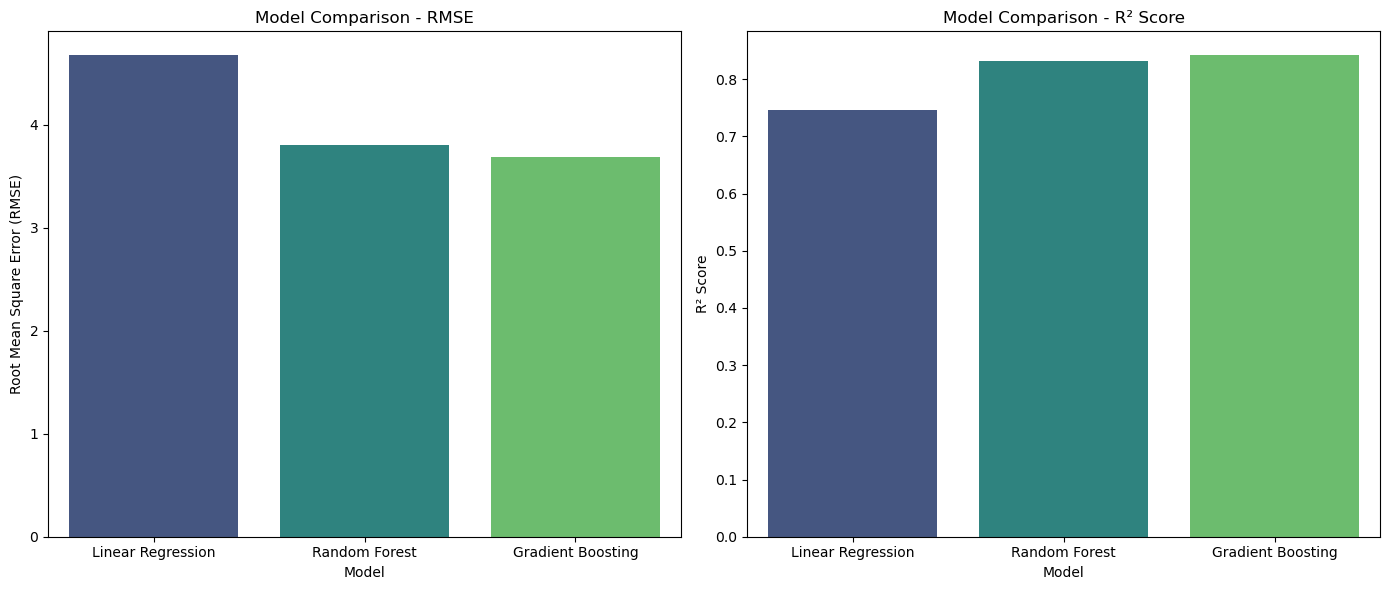

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot RMSE comparison
sns.barplot(x='Model', y='RMSE', data=performance_df, ax=axes[0], palette='viridis')
axes[0].set_title('Model Comparison - RMSE')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Root Mean Square Error (RMSE)')

# Plot R² Score comparison
sns.barplot(x='Model', y='R2 Score', data=performance_df, ax=axes[1], palette='viridis')
axes[1].set_title('Model Comparison - R² Score')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')

# Show the plots
plt.tight_layout()
plt.show()


Based on the evaluation metrics, Gradient Boosting is the most suitable model for this fare prediction task, as it demonstrates the highest accuracy (R² score of 0.84) and the lowest error (RMSE of 3.68). It is recommended to proceed with Gradient Boosting for deployment or further fine-tuning, as it is likely to deliver the most reliable predictions in real-world scenarios.

###### Creating an App using Streamlit

In [107]:
import joblib

# Save the model
joblib.dump(gb, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

In [108]:
import streamlit as st
import joblib
import numpy as np
from datetime import datetime

# Load the saved model
model = joblib.load('gradient_boosting_model.pkl')

# Define the main function for the app
def main():
    st.title("Uber Fare Prediction App")
    st.write("This app predicts the fare amount for an Uber ride based on input features.")
    
    # Input fields for features
    passenger_count = st.number_input("Passenger Count", min_value=1, max_value=6, value=1, step=1)
    
    # Date input with restricted range between 2009 and 2015
    date = st.date_input(
        "Date of Ride", 
        value=datetime(2015, 1, 1),
        min_value=datetime(2009, 1, 1),
        max_value=datetime(2015, 12, 31)
    )
    
    # Extract year, month, and day from date
    year = date.year
    month = date.month
    day = date.day

    # Time input (hour and minute)
    time_input = st.time_input("Pickup Time", value=datetime(2015, 1, 1, 11, 0), step=60)
    
    # Extract hour and minute from the time input
    hour = time_input.hour
    minute = time_input.minute

    # Distance input
    distance_km = st.number_input("Distance (km)", min_value=0.1, value=5.0, step=0.1)

    # Predict button
    if st.button("Predict Fare"):
        # Make prediction
        features = np.array([[passenger_count, year, month, day, hour + minute / 60, distance_km]])
        prediction = model.predict(features)
        
        # Display the prediction
        st.write(f"Predicted Fare Amount: ${prediction[0]:.2f}")

if __name__ == "__main__":
    main()


2024-11-14 16:42:35.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 16:42:35.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 16:42:35.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 16:42:35.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 16:42:35.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 16:42:35.537 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 16:42:35.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-14 16:42:35.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar